In [0]:
import keras
import csv
import os
import itertools
import numpy as np
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from google.colab import drive, files
from tensorboardcolab import *
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
TRAIN_DIR = r'/content/drive/My Drive/domain_adaptation_images/amazon/images'
VAL_DIR =  r'/content/drive/My Drive/domain_adaptation_images/dslr/images'
TEST_DIR =  r'/content/drive/My Drive/domain_adaptation_images/webcam/images'

In [0]:
img_width, img_height = 520, 520

In [0]:
batch_size = 32
epoch = 10
drop_prob = 0.5
out_class = 31

In [0]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [0]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [0]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 2817 images belonging to 31 classes.


In [0]:
val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 498 images belonging to 31 classes.


In [0]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 795 images belonging to 31 classes.


In [0]:
input_ = Input(shape=(img_width, img_height, 3))
transfer_model = VGG19(input_tensor = input_, weights = 'imagenet', include_top = False)

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
x = transfer_model.output

x = MaxPooling2D()(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(inputs = transfer_model.input, outputs = out)

In [0]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [0]:
for layer in transfer_model.layers:
    layer.trainable = False

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 520, 520, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 520, 520, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 520, 520, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 260, 260, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 260, 260, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 260, 260, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 130, 130, 128)     0         
__________

In [0]:
tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

Wait for 8 seconds...
TensorBoard link:
http://4dc98355.ngrok.io


In [0]:
checkpointer = ModelCheckpoint(filepath='checkpoint_vgg19.h5', save_best_only=True)

In [0]:
callback_list = [tensorboard, checkpointer]

In [0]:
model.fit_generator(train_generator, steps_per_epoch = int(2817/batch_size), epochs = epoch, shuffle = True, 
                   validation_data = val_generator, validation_steps = int(498/batch_size), callbacks = callback_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
88/88 [==============================] - 247s 3s/step - loss: 3.1568 - acc: 0.1637 - val_loss: 2.9496 - val_acc: 0.1771
Epoch 2/10
88/88 [==============================] - 225s 3s/step - loss: 2.3348 - acc: 0.3520 - val_loss: 2.7300 - val_acc: 0.2639
Epoch 3/10
88/88 [==============================] - 215s 2s/step - loss: 1.9458 - acc: 0.4688 - val_loss: 2.7064 - val_acc: 0.3283
Epoch 4/10
88/88 [==============================] - 215s 2s/step - loss: 1.7427 - acc: 0.5228 - val_loss: 2.4569 - val_acc: 0.3734
Epoch 5/10
88/88 [==============================] - 216s 2s/step - loss: 1.5500 - acc: 0.5796 - val_loss: 2.4366 - val_acc: 0.3433
Epoch 6/10
88/88 [==============================] - 217s 2s/step - loss: 1.3962 - acc: 0.6175 - val_loss: 2.4492 - val_acc: 0.3455
Epoch 7/10
88/88 [==============================] - 215s 2s/step - loss: 1.2695 - acc: 0.6587 - val_loss: 2.3743 - val_acc: 0.4034
Epoch 8/10
88/88 [=================

In [0]:
Y_pred = model.predict_generator(test_generator, int(795/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [0]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(795/batch_size+1))

In [0]:
test_loss

2.372938985344749

In [0]:
test_accuracy

0.33962264158440836

In [0]:
model_check = load_model('checkpoint_vgg19.h5')

In [0]:
test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [0]:
test_check_loss

2.391364581629915

In [0]:
test_check_acc

0.33836477946185467

In [0]:
target_names = ['Back pack', 'Bike', 'Bike Helmet', 'Bookcase', 'Bottle', 'Calculator', 'Desk chair', 'Desk lamp', 'Desktop computer', 'File cabinet', 
               'Headphones', 'Keyboard', 'Laptop', 'Letter tray', 'Mobile phone', 'Monitor', 'Mouse', 'Mug', 'Paper Notebook', 'Pen', 'Phone', 'Printer', 'Projector', 
               'Punchers', 'Ring binder', 'Ruler', 'Scissors', 'Speaker', 'Stapler', 'Tape dispenser', 'Trash can']

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [0]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[0 1 1 0 1 0 1 1 0 2 0 0 1 3 0 0 0 3 1 1 1 1 1 1 0 0 3 4 2 0 0]
 [0 1 2 0 0 0 0 1 0 1 1 1 0 3 0 1 0 0 0 3 3 0 0 0 0 0 0 0 4 0 0]
 [0 0 1 0 0 0 1 4 0 2 2 1 1 3 0 0 3 1 0 1 2 0 0 0 0 1 3 0 1 1 0]
 [0 0 3 0 0 0 0 3 0 0 0 0 0 2 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 4 1 0 0 1 0 0 1 0 0 4 1 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 3 0 4 0 0 0 2 0 1 3 2 0 1 0 1 0 2 0 0 4 3 2 0 0]
 [0 3 1 1 0 0 0 6 0 2 2 5 0 3 0 0 1 2 0 1 0 0 2 1 1 1 4 0 4 0 0]
 [2 1 0 0 0 0 1 1 0 0 0 0 0 1 0 2 1 1 0 2 0 0 0 0 1 2 1 0 1 0 1]
 [0 0 1 0 0 1 0 1 0 0 0 0 2 4 0 0 0 2 0 0 2 2 0 0 2 0 3 0 0 1 0]
 [0 1 1 0 0 0 2 2 0 2 0 0 0 3 0 1 1 1 0 0 0 1 0 1 0 1 2 0 0 0 0]
 [0 1 0 0 0 0 1 4 1 2 0 1 1 1 0 1 1 1 0 1 0 2 1 0 0 2 5 1 0 0 0]
 [1 0 0 0 0 1 0 2 0 2 2 1 2 5 0 0 0 0 0 4 0 1 1 1 0 0 2 1 1 0 0]
 [0 0 1 0 0 1 2 2 0 1 0 1 0 3 0 1 3 2 0 1 2 1 1 0 0 1 2 1 2 2 0]
 [0 1 0 0 0 0 0 1 0 3 1 1 0 1 0 0 2 1 0 0 2 1 0 0 0 1 1 1 0 2 0]
 [0 0 3 0 0 1 0 2 0 2 1 0 0 3 0 1 3 0 2 3 0 1 0 1 0 0 5 1 1 0 0]
 [0 1 1 

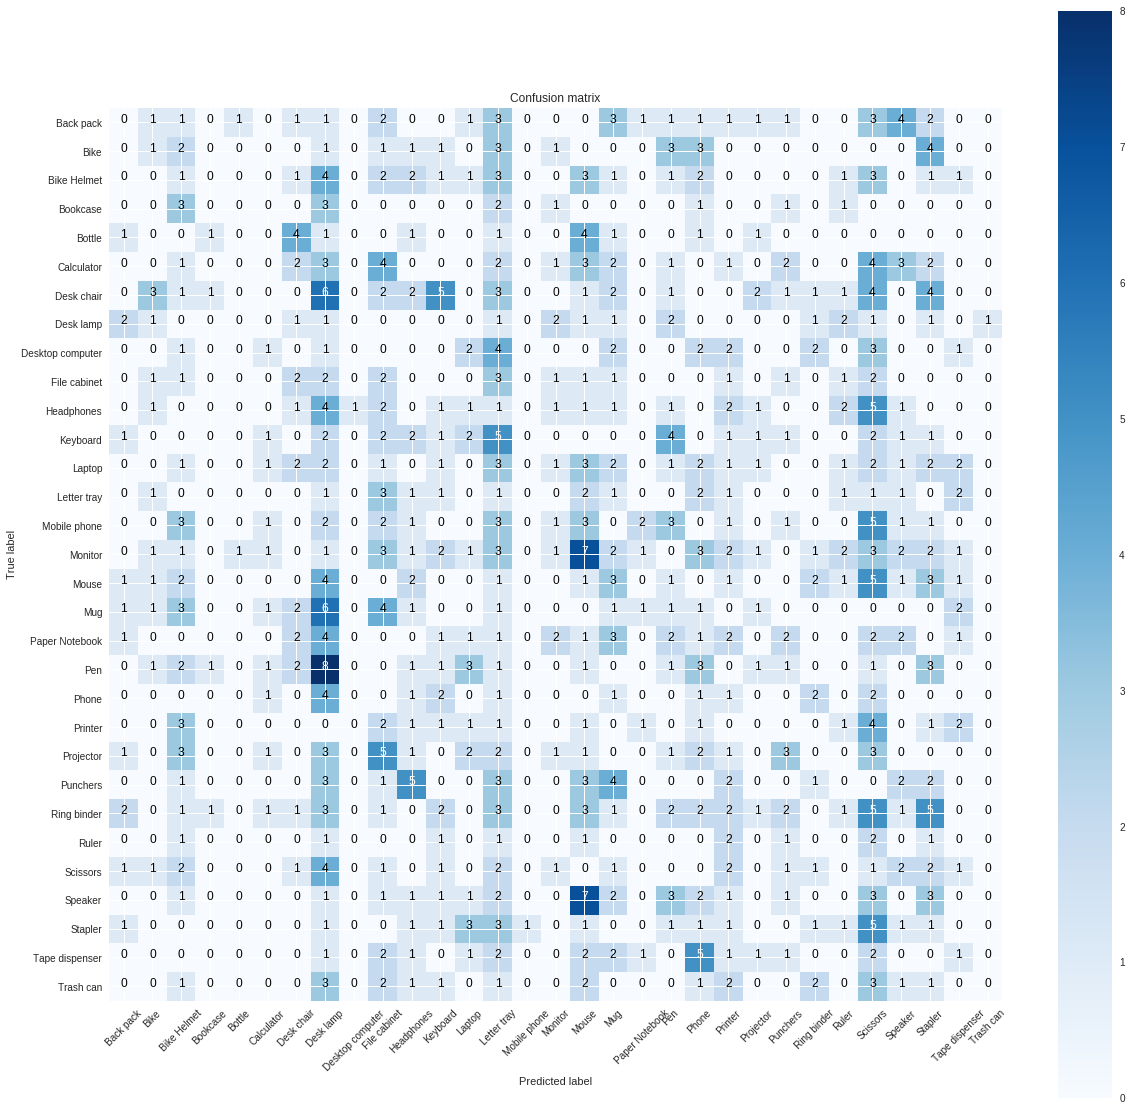

In [0]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [0]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

       Back pack       0.00      0.00      0.00        29
            Bike       0.07      0.05      0.06        21
     Bike Helmet       0.03      0.04      0.03        28
        Bookcase       0.00      0.00      0.00        12
          Bottle       0.00      0.00      0.00        16
      Calculator       0.00      0.00      0.00        31
      Desk chair       0.00      0.00      0.00        40
       Desk lamp       0.01      0.06      0.02        18
Desktop computer       0.00      0.00      0.00        21
    File cabinet       0.04      0.11      0.06        19
      Headphones       0.00      0.00      0.00        27
        Keyboard       0.04      0.04      0.04        27
          Laptop       0.00      0.00      0.00        30
     Letter tray       0.02      0.05      0.02        19
    Mobile phone       0.00      0.00      0.00        30
         Monitor       0.07      0.02      0.04  

In [0]:
model.save('vgg19.h5')

In [0]:
files.download('vgg19.h5')

In [0]:
files.download('checkpoint_vgg19.h5')